In [1]:

# 机器视觉
''' 
改进模型泛化的方法:图像增广和微调

在 7.1节中，我们提到过⼤型数据集是成功应⽤深度神经⽹络的先决条件。图像增⼴在对训练图像进⾏⼀系
列的随机变化之后，⽣成相似但不同的训练样本，从⽽扩⼤了训练集的规模。此外，应⽤图像增⼴的原因是，
随机改变训练样本可以减少模型对某些属性的依赖，从⽽提⾼模型的泛化能⼒。例如，我们可以以不同的⽅
式裁剪图像，使感兴趣的对象出现在不同的位置，减少模型对于对象出现位置的依赖。我们还可以调整亮度、
颜⾊等因素来降低模型对颜⾊的敏感度。可以说，图像增⼴技术对于AlexNet的成功是必不可少的。在本节
中，我们将讨论这项⼴泛应⽤于计算机视觉的技术。
--------------------------------------------------------------------------------------------
%matplotlib inline 
是一个魔法函数(Magic Functions).官方给出的定义是：IPython有一组预先定义好的所谓的魔法函数
你可以通过命令行的语法形式来访问它们。可见“%matplotlib inline”就是模仿命令行来访问magic函
数的在IPython中独有的形式。

#内嵌画图
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf') 
plt.plot((1,2,3),(4,3,-1)) # (1,4) (2,3) (3,-1) 三个点
plt.xlabel(u'横坐标',  fontproperties=myfont) 
plt.ylabel(u'纵坐标',  fontproperties=myfont) 
#plt.show() # 有了%matplotlib inline 就可以省掉plt.show()了

总结：%matplotlib inline 可以在Ipython编译器里直接使用，
功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。
'''
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

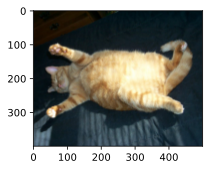

In [37]:
# 常用图像增广方法
# 在对常⽤图像增⼴⽅法的探索时，我们将使⽤下⾯这个尺⼨为400 × 500的图像作为⽰例。
d2l.set_figsize(figsize=(3.5, 2.5)) # Set the figure size for matplotlib. 默认figsize=(3.5, 2.5)
img = d2l.Image.open('../img/cat1.jpg')
# plt.imshow()函数负责对图像进行处理，并显示其格式
# TODO: 为什么在句末添加分号?
d2l.plt.imshow(img);

In [23]:
''' 
⼤多数图像增⼴⽅法都具有⼀定的随机性。为了便于观察图像增⼴的效果，我们下⾯定义辅助函数apply。
此函数在输⼊图像img上多次运⾏图像增⼴⽅法aug并显⽰所有结果 imgaug 图像增强库 augment 增强
'''
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5): # 两行四列
    Y = [aug(img) for _ in range(num_rows * num_cols)] # _ 临时变量 增强图片,num_rows * num_cols张
    d2l.show_images(Y, num_rows, num_cols, scale=scale) # 展示图片,两行四列 scale 数值范围,刻度

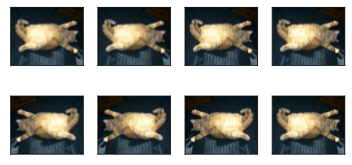

In [24]:
# 翻转和裁剪
''' 
左右翻转图像通常不会改变对象的类别。这是最早且最⼴泛使⽤的图像增⼴⽅法之⼀。接下来，我们使
⽤transforms模块来创建RandomFlipLeftRight实例，这样就各有50%的⼏率使图像向左或向右翻转。

基于Pytorch的工具集，torchtext 处理自然语言，torchaudio 处理音频,torchvision 处理图像视频
torchvision.transforms 是pytorch中的图像预处理包,用于常见的一些图形变换

aug -> torchvision.transforms.RandomHorizontalFlip() # 随机水平翻转
'''
apply(img, torchvision.transforms.RandomHorizontalFlip())

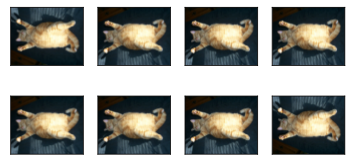

In [25]:
''' 
上下翻转图像不如左右图像翻转那样常⽤。但是，⾄少对于这个⽰例图像，上下翻转不会妨碍识别。接下来，
我们创建⼀个RandomFlipTopBottom实例，使图像各有50%的⼏率向上或向下翻转。

RandomFlip 随机翻转 
'''
apply(img, torchvision.transforms.RandomVerticalFlip())

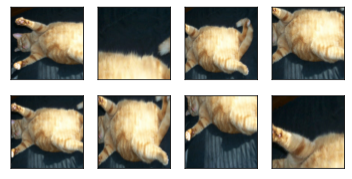

In [26]:
''' 
在我们使⽤的⽰例图像中，猫位于图像的中间，但并⾮所有图像都是这样。在 6.5节中，我们解释了汇聚层可
以降低卷积层对⽬标位置的敏感性。另外，我们可以通过对图像进⾏随机裁剪，使物体以不同的⽐例出现在
图像的不同位置。这也可以降低模型对⽬标位置的敏感性。

在下⾯的代码中，我们随机裁剪⼀个⾯积为原始⾯积10%到100%的区域，该区域的宽⾼⽐从0.5到2之间随机
取值。然后，区域的宽度和⾼度都被缩放到200像素。在本节中（除⾮另有说明），a和b之间的随机数指的是
在区间[a, b]中通过均匀采样获得的连续值。

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5): # 两行四列
    Y = [aug(img) for _ in range(num_rows * num_cols)] # _ 临时变量 增强图片,num_rows * num_cols张
    d2l.show_images(Y, num_rows, num_cols, scale=scale) # 展示图片,两行四列 scale 数值范围,刻度

'''
# 高宽缩放到200,随机裁剪原图范围scale=(0.1, 1), 高宽比ratio=(0.5, 2)均匀随机采样
# apply(img, aug, num_rows=2, num_cols=4, scale=1.5)
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)) 
apply(img, shape_aug) # shape_aug 增强方式 展示使刻度放大到1.5倍

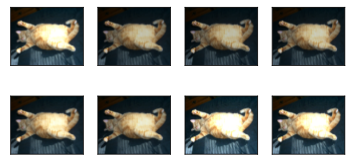

In [27]:
# 改变颜色
''' 
另⼀种增⼴⽅法是改变颜⾊。我们可以改变图像颜⾊的四个⽅⾯：亮度、对⽐度、饱和度和⾊调。在下⾯的
⽰例中，我们随机更改图像的亮度，随机值为原始图像的50%（1 − 0.5）到150%（1 + 0.5）之间。

# ColorJitter 色彩抖动器
ColorJitter(self, brightness=0, contrast=0, saturation=0, hue=0)
'''
# 此处只随机更改了亮度,浮动为0.5
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0)) # 亮度 对比度 饱和度 色调

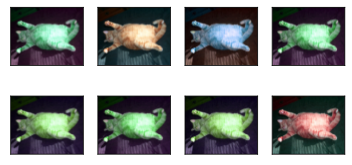

In [28]:
# 同样，我们可以随机更改图像的⾊调。
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

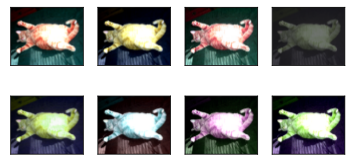

In [29]:
''' 
我们还可以创建⼀个 RandomColorJitter(随机瑟赛抖动器) 实例，并设置如何同时随机更改图像的亮度（brightness）
对⽐度（contrast）、饱和度（saturation）和⾊调（hue）。
'''
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5) # 创建实例
apply(img, color_aug)

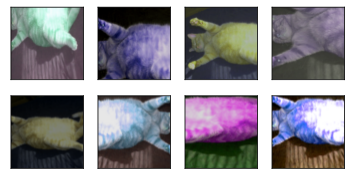

In [30]:
# 结合多种推向增广方法
''' 
在实践中，我们将结合多种图像增⼴⽅法。⽐如，我们可以通过使⽤⼀个Compose实例来综合上⾯定义的不
同的图像增⼴⽅法，并将它们应⽤到每个图像。

# 亮度 对比度 饱和度 色调 
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5) 
    
# 高宽缩放到200,随机裁剪原图范围 scale=(0.1, 1), 高宽比变为ratio=(0.5, 2) 均匀随机采样
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)) 
'''
# 随机水平翻转 颜色增强 形状增强 
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug]) # Compose 组合
apply(img, augs)

Files already downloaded and verified


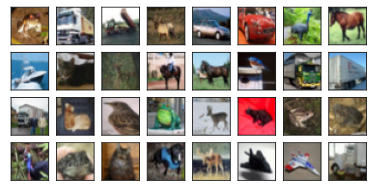

In [39]:
# 使用图像增广进行训练
''' 

让我们使⽤图像增⼴来训练模型。这⾥，我们使⽤CIFAR-10数据集，⽽不是我们之前使⽤的Fashion-MNIST数
据集。这是因为Fashion-MNIST数据集中对象的位置和⼤⼩已被规范化，⽽CIFAR-10数据集中对象的颜⾊和
⼤⼩差异更明显。CIFAR-10数据集中的前32个训练图像如下所⽰
'''
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [40]:
''' 
为了在预测过程中得到确切的结果，我们通常对训练样本只进⾏图像增⼴，且在预测过程中不使⽤随机操作
的图像增⼴。在这⾥，我们只使⽤最简单的随机左右翻转。此外，我们使⽤ToTensor实例将⼀批图像转换
为深度学习框架所要求的格式，即形状为（批量⼤⼩，通道数，⾼度，宽度）的32位浮点数，取值范围为0到1。
----------------------------------------------------------------------------------------------
torchvision是pytorch的一个图形库，它服务于PyTorch深度学习框架的，
主要用来构建计算机视觉模型。torchvision.transforms主要是用于常见的一些图形变换
torchvision.transforms.Compose()类的主要作用是串联多个图片变换的操作
Compose里面的参数实际上就是个列表，而这个列表里面的元素就是你想要执行的transform操作

torchvision.transforms.ToTensor() 将PIL.Image或ndarray从(H x W x C)形状转换为(C x H x W)的tensor
即将 高 宽 通道 转换为 通道 高 宽 ,并且会将数值/255进行归一化

如果转换前numpy.ndarray的dtype = np.uint8
转换前的PIL.Image是L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1 格式
还会将数值从 [0, 255] 归一化到[0,1],不符合上边条件的话就不会归一化。

PIL(Python Image Library) python的第三方图像处理库
'''
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()]) # 对训练集进行随机水平翻转,并转换为适合的格式
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()]) # 对测试集只将其转换为合适的格式

In [41]:
''' 
接下来，我们定义⼀个辅助函数，以便于读取图像和应⽤图像增⼴。PyTorch数据集提供的 transform 函数
应⽤图像增⼴来转化图像。有关DataLoader的详细介绍，请参阅 3.5节。

def get_dataloader_workers(): #@save
    """使⽤4个进程来读取数据"""
    return 4

all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
上述主要为对单图像进行转换,下使用 torchvision.datasets.CIFAR10()中的 transform 函数对数据集
进行图像增广,即其中内置了用于图像增强的接口

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()]) # 对训练集进行随机水平翻转,并转换为适合的格式

transform (callable, optional): 接收 PIL 图像并返回转换后版本的函数/转换
'''
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True) # 数据集增广
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers()) # shuffle 打乱
    return dataloader

In [42]:
# 多GPU训练
''' 
我们在CIFAR-10数据集上训练 7.6节中的ResNet-18模型。回想⼀下 12.6节中对多GPU训练的介绍。接下来，我
们定义⼀个函数，使⽤多GPU对模型进⾏训练和评估。
'''
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


In [43]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    # 梯度的聚合在GPU0上完成并将更新后的参数广播给所有GPU
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # 在模块级别实现数据平行
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [44]:
''' 
现在，我们可以定义train_with_data_aug函数，使⽤图像增⼴来训练模型。该函数获取所有的GPU，
并使⽤Adam作为训练的优化算法，将图像增⼴应⽤于训练集，最后调⽤刚刚定义的⽤于训练和评估模型
的train_ch13函数。

resnet18(num_classes, in_channels=1)
-----------------------------------------------------------------------------------------------
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True) # 数据集增广
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers()) # shuffle 打乱
    return dataloader
-----------------------------------------------------------------------------------------------
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()]) # 对训练集进行随机水平翻转,并转换为适合的格式
    
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()]) # 对测试集只将其转换为合适的格式
'''
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

# 使用图像增强后的数据进行训练,即对数据进行增广后再进行加载
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size) # 训练,增强
    test_iter = load_cifar10(False, test_augs, batch_size) # 不打乱 test_augs中只有格式转换
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices) 

loss 0.175, train acc 0.938, test acc 0.853
1887.0 examples/sec on [device(type='cuda', index=0)]


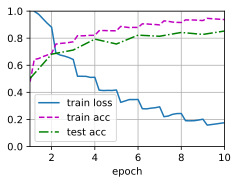

In [45]:
# 让我们使⽤基于随机左右翻转的图像增⼴来训练模型。
train_with_data_aug(train_augs, test_augs, net)

In [ ]:
''' 
⼩结
• 图像增⼴基于现有的训练数据⽣成随机图像，来提⾼模型的泛化能⼒。
• 为了在预测过程中得到确切的结果，我们通常对训练样本只进⾏图像增⼴，⽽在预测过程中不使⽤带
随机操作的图像增⼴。
• 深度学习框架提供了许多不同的图像增⼴⽅法，这些⽅法可以被同时应⽤。
'''